This notebook runs a recording of pre-determined length on the PiDAQ

## Import required modules

In [1]:
%matplotlib widget

import pydaqhat as py
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import soundfile as sf
from mutagen.flac import FLAC

## Perform single recording
Returns result of a finite scan to data. DAQ settings can be configured below.

In [2]:
channels = [0] # Channels to use
iepe_enable = False # Enable/disable IEPE
sensitivity = 1000 # Sensitivity in mV/unit
sample_rate = 20480 # Number of samples per second
recording_length = 3 # Length of recording in seconds
unit = ("Voltage", "V") # Unit of measurement. Format is (unit_name, unit_unit)

data = py.finite_scan(
    channels=channels, 
    iepe_enable=iepe_enable, 
    sensitivity=sensitivity, 
    sample_rate=sample_rate, 
    recording_length=recording_length
)

Found a board at address: 0
Recording will start with parameters
                Channels: [0]
                IEPE: False
                Requested Scan Rate: 20480 Hz
                Actual Scan Rate: 17066.667 Hz
                Length of Recording: 3 seconds
                Sensitivity: 1000 mV/unit
                Option Flags: DEFAULT
                
Starting scan...
Recording finished with 61440 samples


## Save Recording as FLAC

In [29]:
filename = "data/finite_recording_0.flac"
hat = py.get_hat()
actual_sample_rate = round(hat.a_in_scan_actual_rate(sample_rate))

sf.write(filename, data.data, actual_sample_rate)

file = FLAC(filename)
file["Title"] = "Finite Recording"
file["Channels Used"] = str(channels)
file["IEPE Enable"] = str(iepe_enable)
file["Sensitivity"] = str(sensitivity)
file["Sample Rate"] = str(actual_sample_rate )
file["Unit"] = "{} ({})".format(unit[0], unit[1])

file.save()

print("Recording saved to {}".format(filename))

Recording saved to data/finite_recording_0.flac


## Visualise data

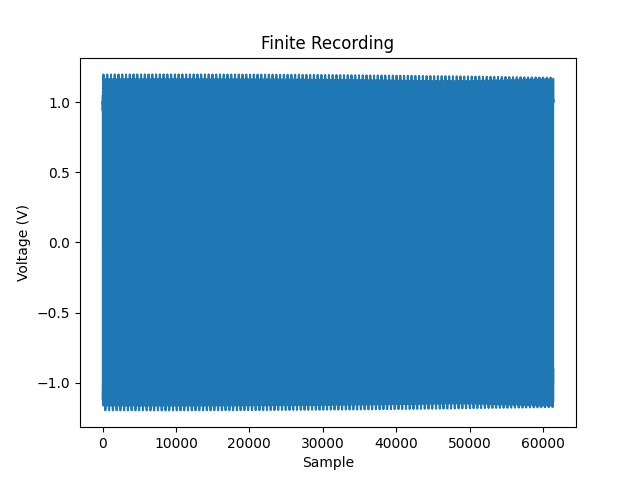

In [3]:
fig = plt.figure()

ax = fig.add_subplot(111)
ax.set_ylabel("{} ({})".format(unit[0], unit[1]))
ax.set_xlabel("Sample")
ax.set_title("Finite Recording")
ax.plot(range(len(data.data)), data.data)

## Visualise data (Bokeh)

In [12]:
from bokeh.plotting import figure
from bokeh.io import push_notebook, show, output_notebook
output_notebook()

Loading BokehJS ...

In [14]:
plot = figure(
    title = "Finite Recording",
    x_axis_label = "Sample",
    y_axis_label = "{} ({})".format(unit[0], unit[1])
)

plot.line(
    range(len(data.data)), 
    data.data
)

show(plot, notebook_handle=True)

## FFT Analysis

In [4]:
import FFTfunctions as fft
import numpy as np

The maximum number of windows for these parameters is 6
The signals have been windowed successfully
avgFFT function operation successful


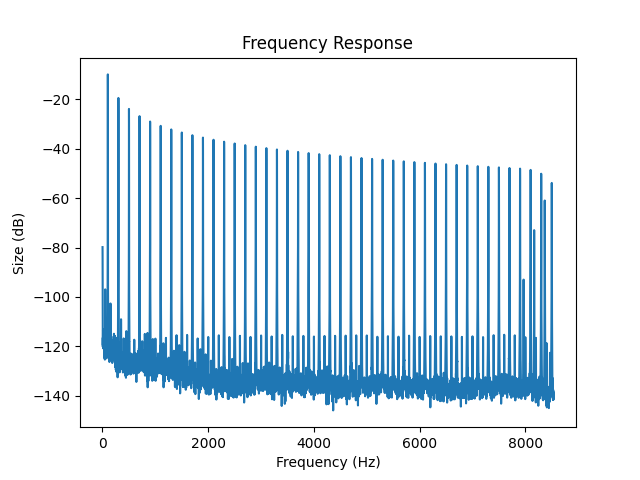

In [5]:
resolution = 1 # Chosen resolution in Hz (freq/second) i.e 1 Hz will have a window size of 1 s, 2 Hz will have a window size of 0.5 s ...
overlap = 0.5 # Overlap percentage of windows
number_of_windows = 6 # Number of windows to average
window_type = 'hann' # Window type
hat = py.get_hat()
actual_sample_rate = round(hat.a_in_scan_actual_rate(sample_rate))

# Calculate the average FFT of the signal
FFTresponse = fft.avgFFT(data.data,
              actual_sample_rate,
              resolution = resolution,
              number_of_windows = number_of_windows,
              overlap = overlap,
              window_type = window_type
             )

# Get x coordinates for plotting
time = np.arange(0, recording_length, 1/actual_sample_rate)
frequency = np.arange(0, actual_sample_rate/2, resolution)
if frequency.size != len(FFTresponse):
    frequency = frequency[1 * resolution: len(frequency)]
    
fig = plt.figure()

ax = fig.add_subplot(111)
ax.set_ylabel("Size (dB)")
ax.set_xlabel("Frequency (Hz)")
ax.set_title("Frequency Response")
ax.plot(frequency, 20 * np.log10(FFTresponse))
